## Importamos las librerias necesarias

In [51]:
#Importamos pandas, numpy
import numpy as np
import pandas as pd

## Importamos el dataset limpio para cargarlo en un dataframe

In [52]:
#Guardamos el path del archivo en una variable para despues cargarlo en un df

file = 'C:/Users/Ramiro/Desktop/Digital House/Desafios/Desafio 2/dataset limpio.csv'

# Creamos un DataFrame con la info del csv
df = pd.read_csv(file)

## Creamos una variable que represente el porcentaje de superficie cubierta de la propiedad

In [53]:
df['Porcentaje_Cubierto'] = df['Metros_Cubiertos']/df['Metros_Totales']

### Dejamos solo las columnas necesarias

In [54]:
df = df[['Tipo_Propiedad', 'Barrio','Provincia', 'Precio', 'Precio_ARS', 'Precio_Dolares', 'Metros_Totales',
       'Metros_Cubiertos', 'Precio_m2_Dls', 'Precio_m2', 'Cantidad_Ambientes','Porcentaje_Cubierto']]

### Como se relacionan las features entre si?

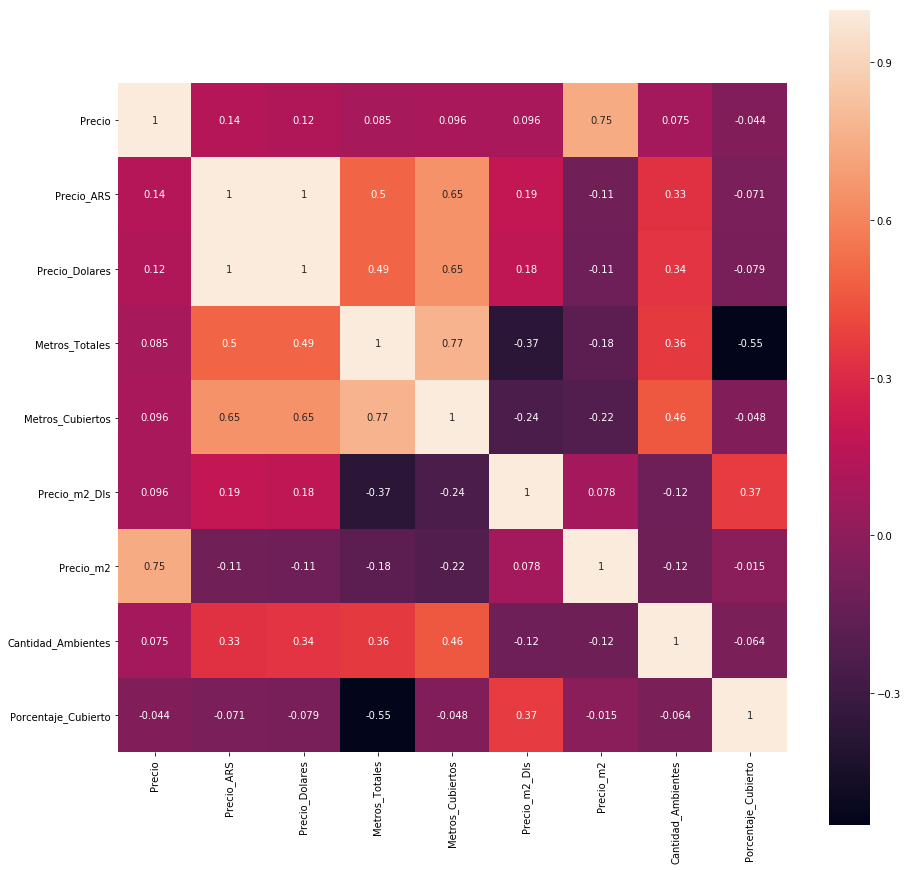

In [55]:
#Graficos la matriz de correlacion
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(15,15))       
sns.heatmap(df.corr() , square=True, annot=True, ax=ax);

In [ ]:
df.info()

### Antes de eliminar observaciones, deberiamos chequear la distribucion por Provincias para asegurarnos que no nos queden zonas sin observaciones

In [ ]:
df['Provincia'].value_counts()

Vemos que en el dataset original existen provincias con muy pocas observaciones. Esto generara que el modelo no pueda predecir correctamente, o del todo, esas provincias.

### Nos quedamos solo con las observaciones que no tienen valores nulos

Prodiamos intentar predecir cualquiera de las variables de precio (en dolares o pesos). Para evaluar que tan bien performan los modelos, vamos a intentar predecir tanto el Precio total en Dolares (Precio_Dls) y el Precio por metro cuadrado en Dolares (Precio_m2_Dls)

In [58]:
df_precio = df.drop(['Precio', 'Precio_ARS','Precio_m2_Dls', 'Precio_m2'], axis = 1)

df_m2 = df.drop(['Precio', 'Precio_Dolares','Precio_m2', 'Precio_ARS'], axis = 1)

In [59]:
df_precio = df_precio.dropna(axis =0 , how = 'any')
df_m2 = df_m2.dropna(axis =0 , how = 'any')

In [60]:
#Dataset Precio total
df_precio['Provincia'].value_counts()

Capital Federal                 21240
Bs.As. G.B.A. Zona Norte        14930
Buenos Aires Costa Atlántica     7228
Bs.As. G.B.A. Zona Sur           6439
Bs.As. G.B.A. Zona Oeste         5369
Córdoba                          4560
Santa Fe                         2855
Buenos Aires Interior            1102
Corrientes                        307
Mendoza                           284
Río Negro                         256
Neuquén                           224
Misiones                          216
Tucumán                           103
Chubut                             97
San Luis                           73
Entre Ríos                         58
Salta                              57
Tierra Del Fuego                   24
Chaco                              16
Santa Cruz                         10
La Pampa                            9
Jujuy                               6
Catamarca                           4
San Juan                            3
La Rioja                            2
Santiago Del

In [61]:
#Dataset Precio m2
df_m2['Provincia'].value_counts()

Capital Federal                 17077
Bs.As. G.B.A. Zona Norte        10966
Buenos Aires Costa Atlántica     5720
Bs.As. G.B.A. Zona Sur           3937
Bs.As. G.B.A. Zona Oeste         3614
Córdoba                          2200
Santa Fe                         1979
Buenos Aires Interior             698
Corrientes                        223
Mendoza                           185
Neuquén                           176
Río Negro                         164
Misiones                          162
Tucumán                           102
Chubut                             91
San Luis                           64
Entre Ríos                         48
Salta                              35
Tierra Del Fuego                   24
Chaco                              16
Santa Cruz                         10
La Pampa                            5
San Juan                            2
Santiago Del Estero                 1
Formosa                             1
La Rioja                            1
Name: Provin

Efectivamente, notamos que al momento de quedarnos solo con las observaciones con todos los valores completos, perdimos Provincias enteras como Formosa, Catamarca y Jujuy.
Esto va a causar que al momento de querer realizar una prediccion sobre una propiedad de esa provincia, el modelo prediga incorrectamente.
Entendemos que es un error a tener en cuenta. La forma de poder corregirlo seria agregar observaciones al dataset.

## Modelado

Para comenzar el modelado, debemos transformar las variables categoricas en dummies, luego normalizaremos las variables para facilitar la corrida de los distintos modelos.
Vamos a modelar primero tratando predecir el Precio total para todo el pais, y luego el precio por metro cuadrado.

Finalmente, generaremos modelos mas acotados (a ciertas provincias o zonas) buscando una performance mejor de los modelos

In [62]:
#Creamos variables dummies de las variables categoricas

#Provincia
df_precio = pd.concat([df_precio, pd.get_dummies(data = df_precio['Provincia'], prefix= 'prov')], axis = 1)
df_m2 = pd.concat([df_m2, pd.get_dummies(data = df_m2['Provincia'], prefix= 'prov')], axis = 1)

#Barrio
df_precio = pd.concat([df_precio, pd.get_dummies(data = df_precio['Barrio'], prefix= 'barrio')], axis =1)
df_m2 = pd.concat([df_m2, pd.get_dummies(data = df_m2['Barrio'], prefix= 'barrio')], axis = 1)

#Tipo Propiedad
df_precio = pd.concat([df_precio, pd.get_dummies(data = df_precio['Tipo_Propiedad'], prefix= 'tipo_prop')], axis =1)
df_m2 = pd.concat([df_m2, pd.get_dummies(data = df_m2['Tipo_Propiedad'], prefix= 'tipo_prop')], axis = 1)

In [63]:
#Dropeo de las columnas originales
df_precio = df_precio.drop(['Provincia','Barrio','Tipo_Propiedad'], axis = 1)
df_m2 = df_m2.drop(['Provincia','Barrio','Tipo_Propiedad'], axis = 1)

#### Importamos todas las librerias necesarias para el modelado

In [64]:
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

#### Armamos nuestro vector objetivo y nuestra matriz de features

In [65]:
#Separamos nuestra matriz de features

X = df_precio.drop(['Precio_Dolares'], axis = 1)
y = df_precio['Precio_Dolares']

#### Separamos los datos en sets de testeo y training

In [66]:
#Separamos en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

### Regresion Lineal

In [67]:
#Instanciamos el modelo

lm = linear_model.LinearRegression()

#Entrenamos el modelo
reg_lineal = lm.fit(X_train, y_train)

#Guardamos el score del modelo en una variable para poder comparar
R2_reg_lin_precio = reg_lineal.score(X_test, y_test)

#Prediccion con el set de testeo

print('Score de Regresion Lineal:', reg_lineal.score(X_test, y_test))

Score de Regresion Lineal: 0.5992405833213271


### Veamos graficamente como se compara el modelo con los valores reales

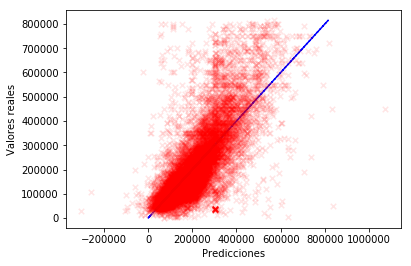

In [83]:
# Graficamos el modelo
plt.scatter(y_pred, y_test, alpha = 0.1,s=30, c='r', marker='x', zorder=10)
plt.plot(y,y, '-.',c='blue')
plt.xlabel("Predicciones")
plt.ylabel("Valores reales")
plt.show()

#### Como predice el mismo modelo el precio por metro cuadrado?

In [17]:
#Separamos nuestra matriz de features

X_m2 = df_m2.drop(['Precio_m2_Dls'], axis = 1)
y_m2 = df_m2['Precio_m2_Dls']

In [18]:
#Separamos en train y test
X_train_m2, X_test_m2, y_train_m2, y_test_m2 = train_test_split(X_m2, y_m2, test_size=0.25, random_state=1)

In [19]:
#Instanciamos el modelo

lm_m2 = linear_model.LinearRegression()

#Entrenamos el modelo
reg_lineal_m2 = lm_m2.fit(X_train_m2, y_train_m2)

#Guardamos el score del modelo en una variable para poder comparar
R2_reg_lin_m2 = reg_lineal_m2.score(X_test_m2, y_test_m2)

#Prediccion con el set de testeo

print('Score de Regresion Lineal:', reg_lineal_m2.score(X_test_m2, y_test_m2))

Score de Regresion Lineal: 0.5986858105824328


### Comparemos los resultados de los dos modelos

In [20]:
print('R2 Modelo Precio: ',R2_reg_lin_precio)
print('Ordenada al origen Modelo Precio: ',reg_lineal.intercept_)
print('R2 Modelo Precio_m2: ', R2_reg_lin_m2)
print('Ordenada al origen Modelo m2: ',reg_lineal_m2.intercept_)

R2 Modelo Precio:  0.5992405833213271
Ordenada al origen Modelo Precio:  10442.482461870997
R2 Modelo Precio_m2:  0.5986858105824328
Ordenada al origen Modelo m2:  453.6718199203351


In [21]:
#Creamos un diccionario con la informacion para luego amar un dataframe y comparar los modelos

rl_argentina_precio = {'Modelo': "Regresion Lineal",
                        'Alcance del modelo': 'Nacional',
                        'Variable Obejtivo': 'Precio_Dolares',
                        'Cantidad de Observaciones': len(df_precio),
                        'R2': R2_reg_lin_precio,
                        'Intercepto': reg_lineal.intercept_}

rl_argentina_m2 = {'Modelo': "Regresion Lineal",
                    'Alcance del modelo': 'Nacional',
                    'Variable Obejtivo': 'Precio_m2_Dls',
                    'Cantidad de Observaciones': len(df_m2),
                    'R2': R2_reg_lin_m2,
                    'Intercepto': reg_lineal_m2.intercept_}

El modelo de regresion lineal multiple es demasiado simple para poder obtener un insight lo suficientemente convincente, por lo cual vamos a aplicar dos modelos que incluyen tecnicas de regularizacion: Ridge y Lasso

### Primero debemos normalizar las features.
Las variables dummies no es necesario que sean normalizadas ya que son variables dicotomicas (0 o 1).

Recordemos que nuestros sets de training y testeo quedaron definidos de la siguiente manera:

`X_train, X_test, y_train, y_test`: Para el modelar el Precio_ARS

`X_train_m2, X_test_m2, y_train_m2, y_test_m2`: Para modelar el Precio_m2

In [22]:
#Importamos StandardScaler para normalizar las variables
from sklearn.preprocessing import StandardScaler
scaler_precio = StandardScaler()
X_train = scaler_precio.fit_transform(X_train)

In [23]:
print('media:',np.mean(X_train[:,1]))
print('desvio:',np.std(X_train[:,1]))

media: 6.598258578690677e-17
desvio: 1.0


## Regresion Lineal Ridge

In [24]:
#Instanciamos el modelo

lm_ridge =  linear_model.RidgeCV(alphas= np.linspace(0.1, 100, 10), cv=5)

#Entrenamos el modelo
reg_lineal_ridge = lm_ridge.fit(X_train, y_train)

# Lo utilizamos para predecir en test
X_test = scaler_precio.transform(X_test)

#Guardamos el score en una variable
score_ridge_precio = reg_lineal_ridge.score(X_test, y_test)

#Prediccion con el set de testeo

print('Score del modelo Ridge:', reg_lineal_ridge.score(X_test, y_test))

Score del modelo Ridge: 0.5988589316822037


#### Como predice el mismo modelo el precio por metro cuadrado?

In [25]:
#Normalizamos las features

scaler_m2 = StandardScaler()
X_train_m2 = scaler_m2.fit_transform(X_train_m2)

In [26]:
print('media:',np.mean(X_train_m2[:,1]))
print('desvio:',np.std(X_train_m2[:,1]))

media: -5.90373753782427e-17
desvio: 0.9999999999999999


In [27]:
#Instanciamos el modelo
lm_ridge_m2 =  linear_model.RidgeCV(alphas=np.linspace(0.1, 100, 10), cv=5)

#Entrenamos el modelo
reg_lineal_ridge_m2 = lm_ridge_m2.fit(X_train_m2, y_train_m2)

# Lo utilizamos para predecir en test
X_test_m2 = scaler_m2.transform(X_test_m2)

score_ridge_m2 = reg_lineal_ridge_m2.score(X_test_m2, y_test_m2)

#Prediccion con el set de testeo
print('Score del modelo Ridge:', reg_lineal_ridge_m2.score(X_test_m2, y_test_m2))

Score del modelo Ridge: 0.6007747101690142


### Comparemos los resultados de los dos modelos

In [28]:
print('Score Ridge Precio: ', score_ridge_precio)
print('Alpha Ridge Precio: ', reg_lineal_ridge.alpha_)
print('Ordenada al origen Precio: ', reg_lineal_ridge.intercept_)
print('Score Ridge m2: ', score_ridge_m2)
print('Alpha Ridge m2: ', reg_lineal_ridge_m2.alpha_)
print('Ordenada al origen m2: ', reg_lineal_ridge_m2.intercept_)

Score Ridge Precio:  0.5988589316822037
Alpha Ridge Precio:  11.200000000000001
Ordenada al origen Precio:  191657.77238102024
Score Ridge m2:  0.6007747101690142
Alpha Ridge m2:  100.0
Ordenada al origen m2:  1958.659124290539


In [29]:
#Creamos un diccionario para luego mostrar los datos en un dataframe

ridge_argentina_precio = {'Modelo': "Regresion Lineal Ridge",
                          'Alcance del modelo': 'Nacional',
                          'Variable Obejtivo': 'Precio_Dolares',
                          'Cantidad de Observaciones': len(df_precio),
                          'R2': score_ridge_precio,
                          'Intercepto': reg_lineal_ridge.intercept_,
                          'Alpha del modelo': reg_lineal_ridge.alpha_}

ridge_argentina_m2 = {'Modelo': "Regresion Lineal Ridge",
                       'Alcance del modelo': 'Nacional',                      
                       'Variable Obejtivo': 'Precio_m2_Dls',
                       'Cantidad de Observaciones': len(df_m2),
                       'R2': score_ridge_m2,
                       'Intercepto': reg_lineal_ridge_m2.intercept_,
                       'Alpha del modelo': reg_lineal_ridge_m2.alpha_}

## Regresion Lasso

In [30]:
#Instanciamos el modelo
lm_lasso =  linear_model.LassoCV(alphas=np.linspace(0.1, 100, 10), cv = 5)

#Entrenamos el modelo
reg_lineal_lasso = lm_lasso.fit(X_train, y_train)

#Guardamos el score
score_lasso_precio = reg_lineal_lasso.score(X_test, y_test)

print('Score del modelo Lasso:', reg_lineal_lasso.score(X_test, y_test))

C:\Users\Ramiro\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Score del modelo Lasso: 0.5990231831722954


#### Como funciona el modelo para el precio por metro cuadrado?

In [31]:
#Instanciamos el modelo
lm_lasso_m2 =  linear_model.LassoCV(alphas=np.linspace(0.1, 100, 10), cv = 5)

#Entrenamos el modelo
reg_lineal_lasso_m2 = lm_lasso_m2.fit(X_train_m2, y_train_m2)

#Guardamos el score
score_lasso_m2 = reg_lineal_lasso_m2.score(X_test_m2, y_test_m2)

print('Score del modelo Lasso:', reg_lineal_lasso_m2.score(X_test_m2, y_test_m2))

C:\Users\Ramiro\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Score del modelo Lasso: 0.6008380750304019


C:\Users\Ramiro\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [32]:
print('Score Lasso Precio: ', score_lasso_precio)
print('Ordenada al origen Lasso Precio: ', reg_lineal_lasso.intercept_)
print('Alpha Lasso Precio: ', reg_lineal_lasso.alpha_)
print('Score Lasso m2: ', score_lasso_m2)
print('Ordenada al origen Lasso m2: ', reg_lineal_lasso_m2.intercept_)
print('Alpha Lasso m2: ', reg_lineal_lasso_m2.alpha_)

Score Lasso Precio:  0.5990231831722954
Ordenada al origen Lasso Precio:  191657.77238102024
Alpha Lasso Precio:  100.0
Score Lasso m2:  0.6008380750304019
Ordenada al origen Lasso m2:  1958.659124290539
Alpha Lasso m2:  0.1


In [33]:
#Creamos un diccionario para luego mostrar los datos en un dataframe

lasso_argentina_precio = {'Modelo': "Regresion Lineal Lasso",
                          'Alcance del modelo': 'Nacional',
                          'Variable Obejtivo': 'Precio_Dolares',
                          'Cantidad de Observaciones': len(df_precio),
                          'R2': score_lasso_precio,
                          'Intercepto': reg_lineal_lasso.intercept_,
                          'Alpha del modelo': reg_lineal_lasso.alpha_}

lasso_argentina_m2 = {'Modelo': "Regresion Lineal Lasso",
                       'Alcance del modelo': 'Nacional',                      
                       'Variable Obejtivo': 'Precio_m2_Dls',
                       'Cantidad de Observaciones': len(df_m2),
                       'R2': score_lasso_m2,
                       'Intercepto': reg_lineal_lasso_m2.intercept_,
                       'Alpha del modelo': reg_lineal_lasso_m2.alpha_}

## Elastic Net

In [34]:
#Instanciamos el modelo

lm_elastic_net =  linear_model.ElasticNetCV(l1_ratio= [.1, .5, .7, .9, .95, .99, 1],cv = 5)

#Entrenamos el modelo
elastic_net = lm_elastic_net.fit(X_train, y_train)

#Guardamos el score
score_EN = elastic_net.score(X_test, y_test)

#Prediccion con el set de testeo

print('Score del modelo Elastic Net:', elastic_net.score(X_test, y_test))

Score del modelo Elastic Net: 0.5990741635847627


### Como funciona el modelo para el precio por metro cuadrado?

In [35]:
#Instanciamos el modelo

lm_elastic_net_m2 =  linear_model.ElasticNetCV(l1_ratio= [.1, .5, .7, .9, .95, .99, 1], alphas = [10, 100, 1000],cv = 5)

#Entrenamos el modelo
elastic_net_m2 = lm_elastic_net_m2.fit(X_train_m2, y_train_m2)

#Guardamos el score
score_EN_m2 = elastic_net_m2.score(X_test_m2, y_test_m2)

#Prediccion con el set de testeo

print('Score del modelo Elastic Net:', elastic_net_m2.score(X_test_m2, y_test_m2))

Score del modelo Elastic Net: 0.5932213724205312


In [36]:
print('Score Elastic Net Precio: ', score_EN)
print('Alpha Elastic Net Precio: ', elastic_net.alpha_)
print('l1_ratio Elastic Net Precio: ', elastic_net.l1_ratio_)
print('Score Elastic Net m2: ', score_EN_m2)
print('Alpha Elastic Net m2: ', elastic_net_m2.alpha_)
print('l1_ratio Elastic Net m2: ', elastic_net_m2.l1_ratio_)

Score Elastic Net Precio:  0.5990741635847627
Alpha Elastic Net Precio:  135.7696116419318
l1_ratio Elastic Net Precio:  1.0
Score Elastic Net m2:  0.5932213724205312
Alpha Elastic Net m2:  10
l1_ratio Elastic Net m2:  1.0


In [37]:
#Creamos un diccionario para luego mostrar los datos en un dataframe

EN_argentina_precio = {'Modelo': "Elastic Net",
                        'Alcance del modelo': 'Nacional',
                        'Variable Obejtivo': 'Precio_Dolares',
                        'Cantidad de Observaciones': len(df_precio),
                        'R2': score_EN,
                        'Intercepto': elastic_net.intercept_,
                        'Alpha del modelo': elastic_net.alpha_,
                        'l1_ratio': elastic_net.l1_ratio_}

EN_argentina_m2 = {'Modelo': "Elastic Net",
                    'Alcance del modelo': 'Nacional',                      
                    'Variable Obejtivo': 'Precio_m2_Dls',
                    'Cantidad de Observaciones': len(df_m2),
                    'R2': score_EN_m2,
                    'Intercepto': elastic_net_m2.intercept_,
                    'Alpha del modelo': elastic_net_m2.alpha_,
                    'l1_ratio': elastic_net_m2.l1_ratio_}

# Modelo para Capital

In [38]:
df_cap = df.loc[df['Provincia']=='Capital Federal']


In [39]:
Cap_precio = df_cap.drop(['Precio', 'Precio_ARS','Precio_m2_Dls', 'Precio_m2'], axis = 1)

Cap_m2 = df_cap.drop(['Precio', 'Precio_Dolares','Precio_m2', 'Precio_ARS'], axis = 1)

In [40]:
Cap_precio = Cap_precio.dropna(axis =0 , how = 'any')
Cap_m2 = Cap_m2.dropna(axis =0 , how = 'any')

In [41]:
#Creamos variables dummies de las variables categoricas

#Barrio
Cap_precio = pd.concat([Cap_precio, pd.get_dummies(data = Cap_precio['Barrio'], prefix= 'barrio')], axis =1)
Cap_m2 = pd.concat([Cap_m2, pd.get_dummies(data = Cap_m2['Barrio'], prefix= 'barrio')], axis = 1)

#Tipo Propiedad
Cap_precio = pd.concat([Cap_precio, pd.get_dummies(data = Cap_precio['Tipo_Propiedad'], prefix= 'tipo_prop')], axis =1)
Cap_m2 = pd.concat([Cap_m2, pd.get_dummies(data = Cap_m2['Tipo_Propiedad'], prefix= 'tipo_prop')], axis = 1)

In [42]:
#Dropeo de las columnas originales
Cap_precio = Cap_precio.drop(['Provincia','Barrio','Tipo_Propiedad'], axis = 1)
Cap_m2 = Cap_m2.drop(['Provincia','Barrio','Tipo_Propiedad'], axis = 1)

In [43]:
#Separamos nuestra matriz de features

X_Cap = Cap_precio.drop(['Precio_Dolares'], axis = 1)
y_Cap = Cap_precio['Precio_Dolares']

#### Separamos los datos en sets de testeo y training

In [44]:
#Separamos en train y test
X_train, X_test, y_train, y_test = train_test_split(X_Cap, y_Cap, test_size=0.10, random_state=1)

### Regresion Lineal

In [45]:
#Instanciamos el modelo

lm_Cap = linear_model.LinearRegression()

#Entrenamos el modelo
reg_lineal_Cap = lm_Cap.fit(X_train, y_train)

#Guardamos el score del modelo en una variable para poder comparar
R2_reg_lin_precio_Cap = reg_lineal_Cap.score(X_test, y_test)

#Prediccion con el set de testeo

print('Score del Regresion Lineal:', reg_lineal_Cap.score(X_test, y_test))

Score del Regresion Lineal: 0.5887793700094165


#### Como predice el mismo modelo el precio por metro cuadrado?

In [46]:
#Separamos nuestra matriz de features

X_Cap_m2 = Cap_m2.drop(['Precio_m2_Dls'], axis = 1)
y_Cap_m2 = Cap_m2['Precio_m2_Dls']

In [47]:
#Separamos en train y test
X_train_cap_m2, X_test_cap_m2, y_train_cap_m2, y_test_cap_m2 = train_test_split(X_Cap_m2, y_Cap_m2, test_size=0.10, random_state=1)

In [48]:
#Instanciamos el modelo

lm_Cap_m2 = linear_model.LinearRegression()

#Entrenamos el modelo
reg_lineal_Cap_m2 = lm_Cap_m2.fit(X_train_cap_m2, y_train_cap_m2)

#Guardamos el score del modelo en una variable para poder comparar
R2_reg_lin_Cap_m2 = reg_lineal_Cap_m2.score(X_test_cap_m2, y_test_cap_m2)

#Prediccion con el set de testeo

print('Score del Regresion Lineal:', reg_lineal_Cap_m2.score(X_test_cap_m2, y_test_cap_m2))

Score del Regresion Lineal: 0.4939090135025794


In [49]:
#Creamos un diccionario con la informacion para luego amar un dataframe y comparar los modelos

rl_capital_precio = {'Modelo': "Regresion Lineal",
                        'Alcance del modelo': 'Capital Federal',
                        'Variable Obejtivo': 'Precio_Dolares',
                        'Cantidad de Observaciones': len(Cap_precio),
                        'R2': R2_reg_lin_precio_Cap,
                        'Intercepto': reg_lineal_Cap.intercept_}

rl_capital_m2 = {'Modelo': "Regresion Lineal",
                    'Alcance del modelo': 'Capital Federal',
                    'Variable Obejtivo': 'Precio_m2_Dls',
                    'Cantidad de Observaciones': len(Cap_m2),
                    'R2': R2_reg_lin_Cap_m2,
                    'Intercepto': reg_lineal_Cap_m2.intercept_}

## Regresion Lineal Ridge para Capital

Recordemos que nuestros sets de training y testeo quedaron definidos de la siguiente manera:

`X_train, X_test, y_train, y_test`: Para el modelar el Precio_ARS

`X_train_cap_m2, X_test_cap_m2, y_train_cap_m2, y_test_cap_m2`: Para modelar el Precio_m2

In [50]:
#Normalizamos X_train
scaler_precio_cap = StandardScaler()
X_train = scaler_precio_cap.fit_transform(X_train)

#Chequeamos la media y el desvio
print('media:',np.mean(X_train[:,1]))
print('desvio:',np.std(X_train[:,1]))

media: 2.9736042509315765e-18
desvio: 1.0


In [51]:
#Instanciamos el modelo
lm_ridge_cap_precio =  linear_model.RidgeCV(alphas= np.linspace(0.1, 100, 10), cv=5)

#Entrenamos el modelo
reg_lineal_ridge_cap_precio = lm_ridge_cap_precio.fit(X_train, y_train)

# Lo utilizamos para predecir en test
X_test = scaler_precio_cap.transform(X_test)

#Guardamos el score en una variable
score_ridge_cap_precio = reg_lineal_ridge_cap_precio.score(X_test, y_test)

#Prediccion con el set de testeo
print('Score del modelo Ridge:', reg_lineal_ridge_cap_precio.score(X_test, y_test))

Score del modelo Ridge: 0.5886948295901331


#### Como predice el mismo modelo el precio por metro cuadrado?

In [52]:
#Normalizamos las features

scaler_cap_m2 = StandardScaler()
X_train_cap_m2 = scaler_cap_m2.fit_transform(X_train_cap_m2)

#Chequeamos la media y el desvio
print('media:',np.mean(X_train_cap_m2[:,1]))
print('desvio:',np.std(X_train_cap_m2[:,1]))

media: -8.460493242507537e-17
desvio: 0.9999999999999999


In [53]:
#Instanciamos el modelo
lm_ridge_cap_m2 =  linear_model.RidgeCV(alphas=np.linspace(0.1, 100, 10), cv=5)

#Entrenamos el modelo
reg_lineal_ridge_cap_m2 = lm_ridge_cap_m2.fit(X_train_cap_m2, y_train_cap_m2)

# Lo utilizamos para predecir en test
X_test_cap_m2 = scaler_cap_m2.transform(X_test_cap_m2)

score_ridge_cap_m2 = reg_lineal_ridge_cap_m2.score(X_test_cap_m2, y_test_cap_m2)

#Prediccion con el set de testeo
print('Score del modelo Ridge:', reg_lineal_ridge_cap_m2.score(X_test_cap_m2, y_test_cap_m2))

Score del modelo Ridge: 0.4937366838481044


In [54]:
print('Score Ridge Precio: ', score_ridge_cap_precio)
print('Alpha Ridge Precio: ', reg_lineal_ridge_cap_precio.alpha_)
print('Score Ridge m2: ', score_ridge_cap_m2)
print('Alpha Ridge m2: ', reg_lineal_ridge_cap_m2.alpha_)

Score Ridge Precio:  0.5886948295901331
Alpha Ridge Precio:  55.60000000000001
Score Ridge m2:  0.4937366838481044
Alpha Ridge m2:  33.400000000000006


In [55]:
#Creamos un diccionario con la informacion para luego amar un dataframe y comparar los modelos

ridge_capital_precio = {'Modelo': "Regresion Lineal Ridge",
                        'Alcance del modelo': 'Capital Federal',
                        'Variable Obejtivo': 'Precio_Dolares',
                        'Cantidad de Observaciones': len(Cap_precio),
                        'R2': score_ridge_cap_precio,
                        'Intercepto': reg_lineal_ridge_cap_precio.intercept_,
                        'Alpha del modelo': reg_lineal_ridge_cap_precio.alpha_}

ridge_capital_m2 = {'Modelo': "Regresion Lineal Ridge",
                    'Alcance del modelo': 'Capital Federal',
                    'Variable Obejtivo': 'Precio_m2_Dls',
                    'Cantidad de Observaciones': len(Cap_m2),
                    'R2': score_ridge_cap_m2,
                    'Intercepto': reg_lineal_ridge_cap_m2.intercept_,
                    'Alpha del modelo': reg_lineal_ridge_cap_m2.alpha_}

## Regresion Lasso para Capital

In [56]:
#Instanciamos el modelo
lm_lasso_cap =  linear_model.LassoCV(alphas=np.linspace(0.1, 100, 10), cv = 5)

#Entrenamos el modelo
reg_lineal_lasso_cap = lm_lasso_cap.fit(X_train, y_train)

#Guardamos el score
score_lasso_cap_precio = reg_lineal_lasso_cap.score(X_test, y_test)

print('Score del modelo Lasso:', reg_lineal_lasso_cap.score(X_test, y_test))

Score del modelo Lasso: 0.5888192479365155


In [57]:
#Instanciamos el modelo
lm_lasso_cap_m2 =  linear_model.LassoCV(alphas=np.linspace(0.1, 100, 10), cv = 5)

#Entrenamos el modelo
reg_lineal_lasso_cap_m2 = lm_lasso_cap_m2.fit(X_train_m2, y_train_m2)

#Guardamos el score
score_lasso_cap_m2 = reg_lineal_lasso_cap_m2.score(X_test_m2, y_test_m2)

print('Score del modelo Lasso:', reg_lineal_lasso_cap_m2.score(X_test_m2, y_test_m2))

C:\Users\Ramiro\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Score del modelo Lasso: 0.6008380750304019


C:\Users\Ramiro\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [58]:
print('Score Lasso Precio: ', score_lasso_cap_precio)
print('Alpha Lasso Precio: ', reg_lineal_lasso_cap.alpha_)
print('Score Lasso m2: ', score_lasso_cap_m2)
print('Alpha Lasso m2: ', reg_lineal_lasso_cap_m2.alpha_)

Score Lasso Precio:  0.5888192479365155
Alpha Lasso Precio:  100.0
Score Lasso m2:  0.6008380750304019
Alpha Lasso m2:  0.1


In [59]:
#Creamos un diccionario con la informacion para luego amar un dataframe y comparar los modelos

lasso_capital_precio = {'Modelo': "Regresion Lineal Lasso",
                        'Alcance del modelo': 'Capital Federal',
                        'Variable Obejtivo': 'Precio_Dolares',
                        'Cantidad de Observaciones': len(Cap_precio),
                        'R2': score_lasso_cap_precio,
                        'Intercepto': reg_lineal_lasso_cap.intercept_,
                        'Alpha del modelo': reg_lineal_lasso_cap.alpha_}

lasso_capital_m2 = {'Modelo': "Regresion Lineal Lasso",
                    'Alcance del modelo': 'Capital Federal',
                    'Variable Obejtivo': 'Precio_m2_Dls',
                    'Cantidad de Observaciones': len(Cap_m2),
                    'R2': score_lasso_cap_m2,
                    'Intercepto': reg_lineal_lasso_cap_m2.intercept_,
                    'Alpha del modelo': reg_lineal_lasso_cap_m2.alpha_}

## Elastic Net para Capital

In [60]:
#Instanciamos el modelo

lm_elastic_net_cap =  linear_model.ElasticNetCV(l1_ratio= [.1, .5, .7, .9, .95, .99, 1],cv = 5)

#Entrenamos el modelo
elastic_net_cap = lm_elastic_net_cap.fit(X_train, y_train)

#Guardamos el score
score_EN_cap_precio = elastic_net_cap.score(X_test, y_test)

#Prediccion con el set de testeo

print('Score del modelo Elastic Net:', elastic_net_cap.score(X_test, y_test))

Score del modelo Elastic Net: 0.5888195288486628


In [61]:
#Instanciamos el modelo

lm_elastic_net_cap_m2 =  linear_model.ElasticNetCV(l1_ratio= [.1, .5, .7, .9, .95, .99, 1], alphas = [10, 100, 10],cv = 5)

#Entrenamos el modelo
elastic_net_cap_m2 = lm_elastic_net_cap_m2.fit(X_train_cap_m2, y_train_cap_m2)

#Guardamos el score
score_EN_cap_m2 = elastic_net_cap_m2.score(X_test_cap_m2, y_test_cap_m2)

#Prediccion con el set de testeo

print('Score del modelo Elastic Net:', elastic_net_cap_m2.score(X_test_cap_m2, y_test_cap_m2))

Score del modelo Elastic Net: 0.4906324165719728


In [62]:
print('Score Elastic Net Precio: ', score_EN_cap_precio)
print('Alpha Elastic Net Precio: ', elastic_net_cap.alpha_)
print('l1_ratio Elastic Net Precio: ', elastic_net_cap.l1_ratio_)
print('Score Elastic Net m2: ', score_EN_cap_m2)
print('Alpha Elastic Net m2: ', elastic_net_cap_m2.alpha_)
print('l1_ratio Elastic Net m2: ', elastic_net_cap_m2.l1_ratio_)

Score Elastic Net Precio:  0.5888195288486628
Alpha Elastic Net Precio:  100.63285565757714
l1_ratio Elastic Net Precio:  1.0
Score Elastic Net m2:  0.4906324165719728
Alpha Elastic Net m2:  10
l1_ratio Elastic Net m2:  1.0


In [63]:
#Creamos un diccionario para luego mostrar los datos en un dataframe

EN_capital_precio = {'Modelo': "Elastic Net",
                        'Alcance del modelo': 'Capital Federal',
                        'Variable Obejtivo': 'Precio_Dolares',
                        'Cantidad de Observaciones': len(Cap_precio),
                        'R2': score_EN_cap_precio,
                        'Intercepto': elastic_net_cap.intercept_,
                        'Alpha del modelo': elastic_net_cap.alpha_,
                        'l1_ratio': elastic_net_cap.l1_ratio_}

EN_capital_m2 = {'Modelo': "Elastic Net",
                    'Alcance del modelo': 'Capital Federal',                      
                    'Variable Obejtivo': 'Precio_m2_Dls',
                    'Cantidad de Observaciones': len(Cap_m2),
                    'R2': score_EN_cap_m2,
                    'Intercepto': elastic_net_cap_m2.intercept_,
                    'Alpha del modelo': elastic_net_cap_m2.alpha_,
                    'l1_ratio': elastic_net_cap_m2.l1_ratio_}

## Modelos para Zona Norte

In [64]:
df_zona_norte = df.loc[df['Provincia']=='Bs.As. G.B.A. Zona Norte']

zona_norte_precio = df_zona_norte.drop(['Precio', 'Precio_ARS','Precio_m2_Dls', 'Precio_m2'], axis = 1)

zona_norte_m2 = df_zona_norte.drop(['Precio', 'Precio_Dolares','Precio_m2', 'Precio_ARS'], axis = 1)

zona_norte_precio = zona_norte_precio.dropna(axis =0 , how = 'any')
zona_norte_m2 = zona_norte_m2.dropna(axis =0 , how = 'any')

#Creamos variables dummies de las variables categoricas

#Barrio
zona_norte_precio = pd.concat([zona_norte_precio, pd.get_dummies(data = zona_norte_precio['Barrio'], prefix= 'barrio')], axis =1)
zona_norte_m2 = pd.concat([zona_norte_m2, pd.get_dummies(data = zona_norte_m2['Barrio'], prefix= 'barrio')], axis = 1)

#Tipo Propiedad
zona_norte_precio = pd.concat([zona_norte_precio, pd.get_dummies(data = zona_norte_precio['Tipo_Propiedad'], prefix= 'tipo_prop')], axis =1)
zona_norte_m2 = pd.concat([zona_norte_m2, pd.get_dummies(data = zona_norte_m2['Tipo_Propiedad'], prefix= 'tipo_prop')], axis = 1)

#Dropeo de las columnas originales
zona_norte_precio = zona_norte_precio.drop(['Provincia','Barrio','Tipo_Propiedad'], axis = 1)
zona_norte_m2 = zona_norte_m2.drop(['Provincia','Barrio','Tipo_Propiedad'], axis = 1)

#Separamos nuestra matriz de features

X_zona_norte = zona_norte_precio.drop(['Precio_Dolares'], axis = 1)
y_zona_norte = zona_norte_precio['Precio_Dolares']


### Regresión Lineal para Zona Norte

In [65]:
#Separamos en train y test
X_train, X_test, y_train, y_test = train_test_split(X_zona_norte, y_zona_norte, test_size=0.25, random_state=99)

In [66]:
#Instanciamos el modelo

lm_zona_norte = linear_model.LinearRegression()

#Entrenamos el modelo
reg_lineal_zona_norte = lm_zona_norte.fit(X_train, y_train)

#Guardamos el score del modelo en una variable para poder comparar
R2_reg_lin_precio_zona_norte = reg_lineal_zona_norte.score(X_test, y_test)

#Prediccion con el set de testeo

print('Score del Regresion Lineal:', reg_lineal_zona_norte.score(X_test, y_test))

Score del Regresion Lineal: 0.6484714167050782


#### Como predice el modelo para el precio por metro cuadrado?

In [67]:
#Separamos nuestra matriz de features

X_zona_norte_m2 = zona_norte_m2.drop(['Precio_m2_Dls'], axis = 1)
y_zona_norte_m2 = zona_norte_m2['Precio_m2_Dls']

#Separamos en train y test
X_train_m2, X_test_m2, y_train_m2, y_test_m2 = train_test_split(X_zona_norte_m2, y_zona_norte_m2, test_size=0.25, random_state=99)

In [68]:
#Instanciamos el modelo

lm_zona_norte_m2 = linear_model.LinearRegression()

#Entrenamos el modelo
reg_lineal_zona_norte_m2 = lm_zona_norte_m2.fit(X_train_m2, y_train_m2)

#Guardamos el score del modelo en una variable para poder comparar
R2_reg_lin_m2_zona_norte = reg_lineal_zona_norte_m2.score(X_test_m2, y_test_m2)

#Prediccion con el set de testeo

print('Score del Regresion Lineal:', reg_lineal_zona_norte_m2.score(X_test_m2, y_test_m2))

Score del Regresion Lineal: 0.5905925819791575


In [69]:
#Creamos un diccionario con la informacion para luego amar un dataframe y comparar los modelos

rl_zona_norte_precio = {'Modelo': "Regresion Lineal",
                        'Alcance del modelo': 'Zona Norte',
                        'Variable Obejtivo': 'Precio_Dolares',
                        'Cantidad de Observaciones': len(zona_norte_precio),
                        'R2': R2_reg_lin_precio_zona_norte,
                        'Intercepto': reg_lineal_zona_norte.intercept_}

rl_zona_norte_m2 = {'Modelo': "Regresion Lineal",
                    'Alcance del modelo': 'Zona Norte',
                    'Variable Obejtivo': 'Precio_m2_Dls',
                    'Cantidad de Observaciones': len(zona_norte_m2),
                    'R2': R2_reg_lin_m2_zona_norte,
                    'Intercepto': reg_lineal_zona_norte_m2.intercept_}

## Modelos para Zonas Geograficas especificas

Por ultimo vamos a intentar predecir nuestras variables objetivo para las distintas zonas geograficas en las que podemos segmentas el pais (NOA, NEA, Patagonia y Cuyo). Debido a las pocas observaciones de algunas provincias, no es factible reducir el analisis a un scope por Provincia individual.

In [70]:
# Armamos los dataframes por region

df_NOA = df.loc[df['Provincia'].isin(['Salta','Jujuy','Catamarca','Santiago Del Estero','Tucumán'])]
df_NEA = df.loc[df['Provincia'].isin(['Formosa','Chaco','Corrientes','Misiones'])]
df_Cuyo = df.loc[df['Provincia'].isin(['Mendoza','San Juan','San Luis','La Rioja'])]
df_Patagonia = df.loc[df['Provincia'].isin(['La Pampa','Neuquén','Río Negro','Chubut','Santa Cruz','Tierra Del Fuego'])]

## NOA

In [71]:
# Creamos los dataframe de precio y precio_m2
NOA_precio = df_NOA.drop(['Precio', 'Precio_ARS','Precio_m2_Dls', 'Precio_m2'], axis = 1)

NOA_m2 = df_NOA.drop(['Precio', 'Precio_Dolares','Precio_m2', 'Precio_ARS'], axis = 1)

NOA_precio = NOA_precio.dropna(axis =0 , how = 'any')
NOA_m2 = NOA_m2.dropna(axis =0 , how = 'any')

#Creamos variables dummies de las variables categoricas

#Provincia
NOA_precio = pd.concat([NOA_precio, pd.get_dummies(data = NOA_precio['Provincia'], prefix= 'prov')], axis =1)
NOA_m2 = pd.concat([NOA_m2, pd.get_dummies(data = NOA_m2['Provincia'], prefix= 'prov')], axis = 1)

#Barrio
NOA_precio = pd.concat([NOA_precio, pd.get_dummies(data = NOA_precio['Barrio'], prefix= 'barrio')], axis =1)
NOA_m2 = pd.concat([NOA_m2, pd.get_dummies(data = NOA_m2['Barrio'], prefix= 'barrio')], axis = 1)

#Tipo Propiedad
NOA_precio = pd.concat([NOA_precio, pd.get_dummies(data = NOA_precio['Tipo_Propiedad'], prefix= 'tipo_prop')], axis =1)
NOA_m2 = pd.concat([NOA_m2, pd.get_dummies(data = NOA_m2['Tipo_Propiedad'], prefix= 'tipo_prop')], axis = 1)

#Dropeo de las columnas originales
NOA_precio = NOA_precio.drop(['Provincia','Barrio','Tipo_Propiedad'], axis = 1)
NOA_m2 = NOA_m2.drop(['Provincia','Barrio','Tipo_Propiedad'], axis = 1)

In [72]:
#Separamos nuestra matriz de features

X_NOA = NOA_precio.drop(['Precio_Dolares'], axis = 1)
y_NOA = NOA_precio['Precio_Dolares']

In [73]:
#Separamos en train y test
X_train_NOA, X_test_NOA, y_train_NOA, y_test_NOA = train_test_split(X_NOA, y_NOA, test_size=0.25, random_state=1)

In [74]:
#Instanciamos el modelo

lm_NOA = linear_model.LinearRegression()

#Entrenamos el modelo
reg_lineal_NOA = lm_NOA.fit(X_train_NOA, y_train_NOA)

#Guardamos el score del modelo en una variable para poder comparar
R2_reg_lin_precio_NOA = reg_lineal_NOA.score(X_test_NOA, y_test_NOA)

#Prediccion con el set de testeo

print('Score del Regresion Lineal:', reg_lineal_NOA.score(X_test_NOA, y_test_NOA))

Score del Regresion Lineal: 0.3810446297986584


#### Como predice el modelo para el m2?

In [75]:
#Separamos nuestra matriz de features

X_NOA_m2 = NOA_m2.drop(['Precio_m2_Dls'], axis = 1)
y_NOA_m2 = NOA_m2['Precio_m2_Dls']

In [76]:
#Separamos en train y test
X_train_NOA_m2, X_test_NOA_m2, y_train_NOA_m2, y_test_NOA_m2 = train_test_split(X_NOA_m2, y_NOA_m2, test_size=0.25, random_state=1)

In [77]:
#Instanciamos el modelo

lm_NOA_m2 = linear_model.LinearRegression()

#Entrenamos el modelo
reg_lineal_NOA_m2 = lm_NOA_m2.fit(X_train_NOA_m2, y_train_NOA_m2)

#Guardamos el score del modelo en una variable para poder comparar
R2_reg_lin_m2_NOA = reg_lineal_NOA_m2.score(X_test_NOA_m2, y_test_NOA_m2)

#Prediccion con el set de testeo

print('Score del Regresion Lineal:', reg_lineal_NOA_m2.score(X_test_NOA_m2, y_test_NOA_m2))

Score del Regresion Lineal: 0.01138230180119959


In [78]:
#Creamos un diccionario con la informacion para luego amar un dataframe y comparar los modelos

rl_NOA_precio = {'Modelo': "Regresion Lineal",
                        'Alcance del modelo': 'NOA',
                        'Variable Obejtivo': 'Precio_Dolares',
                        'Cantidad de Observaciones': len(NOA_precio),
                        'R2': R2_reg_lin_precio_NOA,
                        'Intercepto': reg_lineal_NOA.intercept_}

rl_NOA_m2 = {'Modelo': "Regresion Lineal",
                    'Alcance del modelo': 'NOA',
                    'Variable Obejtivo': 'Precio_m2_Dls',
                    'Cantidad de Observaciones': len(NOA_precio),
                    'R2': R2_reg_lin_m2_NOA,
                    'Intercepto': reg_lineal_NOA_m2.intercept_}

## NEA

In [79]:
# Creamos los dataframe de precio y precio_m2
NEA_precio = df_NEA.drop(['Precio', 'Precio_ARS','Precio_m2_Dls', 'Precio_m2'], axis = 1)

NEA_m2 = df_NEA.drop(['Precio', 'Precio_Dolares','Precio_m2', 'Precio_ARS'], axis = 1)

NEA_precio = NEA_precio.dropna(axis =0 , how = 'any')
NEA_m2 = NEA_m2.dropna(axis =0 , how = 'any')

#Creamos variables dummies de las variables categoricas

#Provincia
NEA_precio = pd.concat([NEA_precio, pd.get_dummies(data = NEA_precio['Provincia'], prefix= 'prov')], axis =1)
NEA_m2 = pd.concat([NEA_m2, pd.get_dummies(data = NEA_m2['Provincia'], prefix= 'prov')], axis = 1)

#Barrio
NEA_precio = pd.concat([NEA_precio, pd.get_dummies(data = NEA_precio['Barrio'], prefix= 'barrio')], axis =1)
NEA_m2 = pd.concat([NEA_m2, pd.get_dummies(data = NEA_m2['Barrio'], prefix= 'barrio')], axis = 1)

#Tipo Propiedad
NEA_precio = pd.concat([NEA_precio, pd.get_dummies(data = NEA_precio['Tipo_Propiedad'], prefix= 'tipo_prop')], axis =1)
NEA_m2 = pd.concat([NEA_m2, pd.get_dummies(data = NEA_m2['Tipo_Propiedad'], prefix= 'tipo_prop')], axis = 1)

#Dropeo de las columnas originales
NEA_precio = NEA_precio.drop(['Provincia','Barrio','Tipo_Propiedad'], axis = 1)
NEA_m2 = NEA_m2.drop(['Provincia','Barrio','Tipo_Propiedad'], axis = 1)


In [80]:
#Separamos nuestra matriz de features

X_NEA = NEA_precio.drop(['Precio_Dolares'], axis = 1)
y_NEA = NEA_precio['Precio_Dolares']

In [81]:
#Separamos en train y test
X_train_NEA, X_test_NEA, y_train_NEA, y_test_NEA = train_test_split(X_NEA, y_NEA, test_size=0.25, random_state=1)

In [82]:
#Instanciamos el modelo

lm_NEA = linear_model.LinearRegression()

#Entrenamos el modelo
reg_lineal_NEA = lm_NEA.fit(X_train_NEA, y_train_NEA)

#Guardamos el score del modelo en una variable para poder comparar
R2_reg_lin_precio_NEA = reg_lineal_NEA.score(X_test_NEA, y_test_NEA)

#Prediccion con el set de testeo

print('Score del Regresion Lineal:', reg_lineal_NEA.score(X_test_NEA, y_test_NEA))


Score del Regresion Lineal: 0.5536738219795687


#### Como predice el modelo para el m2?

In [83]:
#Separamos nuestra matriz de features

X_NEA_m2 = NEA_m2.drop(['Precio_m2_Dls'], axis = 1)
y_NEA_m2 = NEA_m2['Precio_m2_Dls']

In [84]:
#Separamos en train y test
X_train_NEA_m2, X_test_NEA_m2, y_train_NEA_m2, y_test_NEA_m2 = train_test_split(X_NEA_m2, y_NEA_m2, test_size=0.25, random_state=1)

In [85]:
#Instanciamos el modelo

lm_NEA_m2 = linear_model.LinearRegression()

#Entrenamos el modelo
reg_lineal_NEA_m2 = lm_NEA_m2.fit(X_train_NEA_m2, y_train_NEA_m2)

#Guardamos el score del modelo en una variable para poder comparar
R2_reg_lin_m2_NEA = reg_lineal_NEA_m2.score(X_test_NEA_m2, y_test_NEA_m2)

#Prediccion con el set de testeo

print('Score del Regresion Lineal:', reg_lineal_NEA_m2.score(X_test_NEA_m2, y_test_NEA_m2))

Score del Regresion Lineal: 0.6367650017727342


In [86]:
#Creamos un diccionario con la informacion para luego amar un dataframe y comparar los modelos

rl_NEA_precio = {'Modelo': "Regresion Lineal",
                        'Alcance del modelo': 'NEA',
                        'Variable Obejtivo': 'Precio_Dolares',
                        'Cantidad de Observaciones': len(NEA_precio),
                        'R2': R2_reg_lin_precio_NEA,
                        'Intercepto': reg_lineal_NEA.intercept_}

rl_NEA_m2 = {'Modelo': "Regresion Lineal",
                    'Alcance del modelo': 'NEA',
                    'Variable Obejtivo': 'Precio_m2_Dls',
                    'Cantidad de Observaciones': len(NEA_m2),
                    'R2': R2_reg_lin_m2_NEA,
                    'Intercepto': reg_lineal_NEA_m2.intercept_}

## CUYO

In [87]:
# Creamos los dataframe de precio y precio_m2
Cuyo_precio = df_Cuyo.drop(['Precio', 'Precio_ARS','Precio_m2_Dls', 'Precio_m2'], axis = 1)

Cuyo_m2 = df_Cuyo.drop(['Precio', 'Precio_Dolares','Precio_m2', 'Precio_ARS'], axis = 1)

Cuyo_precio = Cuyo_precio.dropna(axis =0 , how = 'any')
Cuyo_m2 = Cuyo_m2.dropna(axis =0 , how = 'any')

#Creamos variables dummies de las variables categoricas

#Provincia
Cuyo_precio = pd.concat([Cuyo_precio, pd.get_dummies(data = Cuyo_precio['Provincia'], prefix= 'prov')], axis =1)
Cuyo_m2 = pd.concat([Cuyo_m2, pd.get_dummies(data = Cuyo_m2['Provincia'], prefix= 'prov')], axis = 1)

#Barrio
Cuyo_precio = pd.concat([Cuyo_precio, pd.get_dummies(data = Cuyo_precio['Barrio'], prefix= 'barrio')], axis =1)
Cuyo_m2 = pd.concat([Cuyo_m2, pd.get_dummies(data = Cuyo_m2['Barrio'], prefix= 'barrio')], axis = 1)

#Tipo Propiedad
Cuyo_precio = pd.concat([Cuyo_precio, pd.get_dummies(data = Cuyo_precio['Tipo_Propiedad'], prefix= 'tipo_prop')], axis =1)
Cuyo_m2 = pd.concat([Cuyo_m2, pd.get_dummies(data = Cuyo_m2['Tipo_Propiedad'], prefix= 'tipo_prop')], axis = 1)

#Dropeo de las columnas originales
Cuyo_precio = Cuyo_precio.drop(['Provincia','Barrio','Tipo_Propiedad'], axis = 1)
Cuyo_m2 = Cuyo_m2.drop(['Provincia','Barrio','Tipo_Propiedad'], axis = 1)

In [88]:
#Separamos nuestra matriz de features

X_Cuyo = Cuyo_precio.drop(['Precio_Dolares'], axis = 1)
y_Cuyo = Cuyo_precio['Precio_Dolares']

In [89]:
#Separamos en train y test
X_train_Cuyo, X_test_Cuyo, y_train_Cuyo, y_test_Cuyo = train_test_split(X_Cuyo, y_Cuyo, test_size=0.25, random_state=1)

In [90]:
#Instanciamos el modelo

lm_Cuyo = linear_model.LinearRegression()

#Entrenamos el modelo
reg_lineal_Cuyo = lm_Cuyo.fit(X_train_Cuyo, y_train_Cuyo)

#Guardamos el score del modelo en una variable para poder comparar
R2_reg_lin_precio_Cuyo = reg_lineal_Cuyo.score(X_test_Cuyo, y_test_Cuyo)

#Prediccion con el set de testeo

print('Score del Regresion Lineal:', reg_lineal_Cuyo.score(X_test_Cuyo, y_test_Cuyo))

Score del Regresion Lineal: 0.5707866187024178


#### Como predice el modelo para m2?

In [91]:
#Separamos nuestra matriz de features

X_Cuyo_m2 = Cuyo_m2.drop(['Precio_m2_Dls'], axis = 1)
y_Cuyo_m2 = Cuyo_m2['Precio_m2_Dls']

In [92]:
#Separamos en train y test
X_train_Cuyo_m2, X_test_Cuyo_m2, y_train_Cuyo_m2, y_test_Cuyo_m2 = train_test_split(X_Cuyo_m2, y_Cuyo_m2, test_size=0.25, random_state=1)

In [93]:
#Instanciamos el modelo

lm_Cuyo_m2 = linear_model.LinearRegression()

#Entrenamos el modelo
reg_lineal_Cuyo_m2 = lm_Cuyo_m2.fit(X_train_Cuyo_m2, y_train_Cuyo_m2)

#Guardamos el score del modelo en una variable para poder comparar
R2_reg_lin_m2_Cuyo = reg_lineal_Cuyo_m2.score(X_test_Cuyo_m2, y_test_Cuyo_m2)

#Prediccion con el set de testeo

print('Score del Regresion Lineal:', reg_lineal_Cuyo_m2.score(X_test_Cuyo_m2, y_test_Cuyo_m2))

Score del Regresion Lineal: 0.06744549661866273


In [94]:
#Creamos un diccionario con la informacion para luego amar un dataframe y comparar los modelos

rl_Cuyo_precio = {'Modelo': "Regresion Lineal",
                        'Alcance del modelo': 'Cuyo',
                        'Variable Obejtivo': 'Precio_Dolares',
                        'Cantidad de Observaciones': len(Cuyo_precio),
                        'R2': R2_reg_lin_precio_Cuyo,
                        'Intercepto': reg_lineal_Cuyo.intercept_}

rl_Cuyo_m2 = {'Modelo': "Regresion Lineal",
                    'Alcance del modelo': 'Cuyo',
                    'Variable Obejtivo': 'Precio_m2_Dls',
                    'Cantidad de Observaciones': len(Cuyo_m2),
                    'R2': R2_reg_lin_m2_Cuyo,
                    'Intercepto': reg_lineal_Cuyo_m2.intercept_}

## PATAGONIA

In [95]:
# Creamos los dataframe de precio y precio_m2
Patagonia_precio = df_Patagonia.drop(['Precio', 'Precio_ARS','Precio_m2_Dls', 'Precio_m2'], axis = 1)

Patagonia_m2 = df_Patagonia.drop(['Precio', 'Precio_Dolares','Precio_m2', 'Precio_ARS'], axis = 1)

Patagonia_precio = Patagonia_precio.dropna(axis =0 , how = 'any')
Patagonia_m2 = Patagonia_m2.dropna(axis =0 , how = 'any')

#Creamos variables dummies de las variables categoricas

#Provincia
Patagonia_precio = pd.concat([Patagonia_precio, pd.get_dummies(data = Patagonia_precio['Provincia'], prefix= 'prov')], axis =1)
Patagonia_m2 = pd.concat([Patagonia_m2, pd.get_dummies(data = Patagonia_m2['Provincia'], prefix= 'prov')], axis = 1)

#Barrio
Patagonia_precio = pd.concat([Patagonia_precio, pd.get_dummies(data = Patagonia_precio['Barrio'], prefix= 'barrio')], axis =1)
Patagonia_m2 = pd.concat([Patagonia_m2, pd.get_dummies(data = Patagonia_m2['Barrio'], prefix= 'barrio')], axis = 1)

#Tipo Propiedad
Patagonia_precio = pd.concat([Patagonia_precio, pd.get_dummies(data = Patagonia_precio['Tipo_Propiedad'], prefix= 'tipo_prop')], axis =1)
Patagonia_m2 = pd.concat([Patagonia_m2, pd.get_dummies(data = Patagonia_m2['Tipo_Propiedad'], prefix= 'tipo_prop')], axis = 1)

#Dropeo de las columnas originales
Patagonia_precio = Patagonia_precio.drop(['Provincia','Barrio','Tipo_Propiedad'], axis = 1)
Patagonia_m2 = Patagonia_m2.drop(['Provincia','Barrio','Tipo_Propiedad'], axis = 1)

In [96]:
#Separamos nuestra matriz de features

X_Patagonia = Patagonia_precio.drop(['Precio_Dolares'], axis = 1)
y_Patagonia = Patagonia_precio['Precio_Dolares']

In [97]:
#Separamos en train y test
X_train_Patagonia, X_test_Patagonia, y_train_Patagonia, y_test_Patagonia = train_test_split(X_Patagonia, y_Patagonia, test_size=0.25, random_state=1)

In [98]:
#Instanciamos el modelo

lm_Patagonia = linear_model.LinearRegression()

#Entrenamos el modelo
reg_lineal_Patagonia = lm_Patagonia.fit(X_train_Patagonia, y_train_Patagonia)

#Guardamos el score del modelo en una variable para poder comparar
R2_reg_lin_precio_Patagonia = reg_lineal_Patagonia.score(X_test_Patagonia, y_test_Patagonia)

#Prediccion con el set de testeo

print('Score del Regresion Lineal:', reg_lineal_Patagonia.score(X_test_Patagonia, y_test_Patagonia))

Score del Regresion Lineal: 0.5061442160283882


#### Como predice el modelo para m2?

In [99]:
#Separamos nuestra matriz de features

X_Patagonia_m2 = Patagonia_m2.drop(['Precio_m2_Dls'], axis = 1)
y_Patagonia_m2 = Patagonia_m2['Precio_m2_Dls']

In [100]:
#Separamos en train y test
X_train_Patagonia_m2, X_test_Patagonia_m2, y_train_Patagonia_m2, y_test_Patagonia_m2 = train_test_split(X_Patagonia_m2, y_Patagonia_m2, test_size=0.25, random_state=1)

In [101]:
#Instanciamos el modelo

lm_Patagonia_m2 = linear_model.LinearRegression()

#Entrenamos el modelo
reg_lineal_Patagonia_m2 = lm_Patagonia_m2.fit(X_train_Patagonia_m2, y_train_Patagonia_m2)

#Guardamos el score del modelo en una variable para poder comparar
R2_reg_lin_m2_Patagonia = reg_lineal_Patagonia_m2.score(X_test_Patagonia_m2, y_test_Patagonia_m2)

#Prediccion con el set de testeo

print('Score del Regresion Lineal:', reg_lineal_Patagonia_m2.score(X_test_Patagonia_m2, y_test_Patagonia_m2))

Score del Regresion Lineal: 0.031377825986014574


In [102]:
#Creamos un diccionario con la informacion para luego amar un dataframe y comparar los modelos

rl_Patagonia_precio = {'Modelo': "Regresion Lineal",
                        'Alcance del modelo': 'Patagonia',
                        'Variable Obejtivo': 'Precio_Dolares',
                        'Cantidad de Observaciones': len(Patagonia_precio),
                        'R2': R2_reg_lin_precio_Patagonia,
                        'Intercepto': reg_lineal_Patagonia.intercept_}

rl_Patagonia_m2 = {'Modelo': "Regresion Lineal",
                    'Alcance del modelo': 'Patagonia',
                    'Variable Obejtivo': 'Precio_m2_Dls',
                    'Cantidad de Observaciones': len(Patagonia_m2),
                    'R2': R2_reg_lin_m2_Patagonia,
                    'Intercepto': reg_lineal_Patagonia_m2.intercept_}

## Comparacion de los distintos modelos

Ahora que tenemos todos los resultados de cada modelo en diccionarios separados, vamos a juntarlos para tener todo en un unico dataframe y poder compararlos mas comodamente

In [103]:
# Creamos una lista de todos los diccionarios
diccionarios = [rl_argentina_precio,
rl_argentina_m2,
ridge_argentina_precio,
ridge_argentina_m2,
lasso_argentina_precio,
lasso_argentina_m2,
EN_argentina_precio,
EN_argentina_m2,
rl_capital_precio,
rl_capital_m2,
ridge_capital_precio,
ridge_capital_m2,
lasso_capital_precio,
lasso_capital_m2,
EN_capital_precio,
EN_capital_m2,
rl_zona_norte_precio,
rl_zona_norte_m2,
rl_NOA_precio,
rl_NOA_m2,
rl_NEA_precio,
rl_NEA_m2,
rl_Cuyo_precio,
rl_Cuyo_m2,
rl_Patagonia_precio,
rl_Patagonia_m2]

In [110]:
#Generamos el dataframe con la info
resultados = pd.DataFrame(diccionarios)

resultados = resultados.rename(columns={'Variable Obejtivo' : 'Variable Objetivo'})

#Ordenamos las columnas para verlo mas comodamente
resultados = resultados[['Modelo','Alcance del modelo','Variable Objetivo','Cantidad de Observaciones','R2','Intercepto','Alpha del modelo','l1_ratio']]

In [112]:
#Chequeamos que se haya generado correctamente
df.head()

,Modelo,Alcance del modelo,Variable Objetivo,Cantidad de Observaciones,R2,Intercepto,Alpha del modelo,l1_ratio
0,Regresion Lineal,Nacional,Precio_Dolares,65474,0.599241,10442.482462,NaN,NaN
1,Regresion Lineal,Nacional,Precio_m2_Dls,47501,0.598686,453.671820,NaN,NaN
2,Regresion Lineal Ridge,Nacional,Precio_Dolares,65474,0.598859,191657.772381,11.2,NaN
3,Regresion Lineal Ridge,Nacional,Precio_m2_Dls,47501,0.600775,1958.659124,100.0,NaN
4,Regresion Lineal Lasso,Nacional,Precio_Dolares,65474,0.599023,191657.772381,100.0,NaN


In [113]:
#Pasamos los datos a un archivo para guardarlo

resultados.to_csv(path_or_buf='C:/Users/Ramiro/Desktop/Digital House/Desafios/Desafio 2/Resultados.csv')

## Graficos comparativos

In [84]:
resultados.head()

,Unnamed: 0,Modelo,Alcance del modelo,Variable Objetivo,Cantidad de Observaciones,R2,Intercepto,Alpha del modelo,l1_ratio
0,0,Regresion Lineal,Nacional,Precio_Dolares,65474,0.599241,10442.482462,NaN,NaN
1,1,Regresion Lineal,Nacional,Precio_m2_Dls,47501,0.598686,453.671820,NaN,NaN
2,2,Regresion Lineal Ridge,Nacional,Precio_Dolares,65474,0.598859,191657.772381,11.2,NaN
3,3,Regresion Lineal Ridge,Nacional,Precio_m2_Dls,47501,0.600775,1958.659124,100.0,NaN
4,4,Regresion Lineal Lasso,Nacional,Precio_Dolares,65474,0.599023,191657.772381,100.0,NaN


In [11]:
#Guardamos los scores de los modelos para graficar
R2_Precio_Nacional = resultados.loc[(resultados['Alcance del modelo']=='Nacional')&(resultados['Variable Objetivo']=='Precio_Dolares'),'R2']
R2_m2_Nacional = resultados.loc[(resultados['Alcance del modelo']=='Nacional')&(resultados['Variable Objetivo']=='Precio_m2_Dls'),'R2']

In [32]:
import plotly.plotly as py
import plotly.graph_objs as go

trace1 = go.Bar(
    x=['Regresion Lineal', 'Ridge', 'Lasso', 'Elastic Net'], #distintos modelos
    y=R2_Precio_Nacional, #R2
    name='Precio_Dolares'
)
trace2 = go.Bar(
    x=['Regresion Lineal', 'Ridge', 'Lasso', 'Elastic Net'],
    y=R2_m2_Nacional,
    name='Precio_m2_Dls'
)

data = [trace1, trace2]
layout = go.Layout(
    title = 'Modelos para todo el Pais',
    yaxis=dict(
        range=[0, 1],
        tick0 = 0,
        dtick = 0.1        
    ),
    barmode='group'
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='grouped-bar')

### Capital Federal

In [33]:
#Guardamos los scores de los modelos para graficar
R2_Precio_Capital = resultados.loc[(resultados['Alcance del modelo']=='Capital Federal')&(resultados['Variable Objetivo']=='Precio_Dolares'),'R2']
R2_m2_Capital = resultados.loc[(resultados['Alcance del modelo']=='Capital Federal')&(resultados['Variable Objetivo']=='Precio_m2_Dls'),'R2']

In [34]:
trace1 = go.Bar(
    x=['Regresion Lineal', 'Ridge', 'Lasso', 'Elastic Net'], #distintos modelos
    y=R2_Precio_Capital, #R2
    name='Precio_Dolares'
)
trace2 = go.Bar(
    x=['Regresion Lineal', 'Ridge', 'Lasso', 'Elastic Net'],
    y=R2_m2_Capital,
    name='Precio_m2_Dls'
)

data = [trace1, trace2]
layout = go.Layout(
    title = 'Modelos para Capital Federal',
    yaxis=dict(
        range=[0, 1],
        tick0 = 0,
        dtick = 0.1        
    ),
    barmode='group'
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='grouped-bar')

### Modelos Zonales

In [37]:
#Guardamos los scores de los modelos para graficar
R2_Precio_zonales = resultados.loc[(resultados['Alcance del modelo'].isin(['Zona Norte','NOA','NEA','Cuyo','Patagonia']))&(resultados['Variable Objetivo']=='Precio_Dolares'),'R2']
R2_m2_zonales = resultados.loc[(resultados['Alcance del modelo'].isin(['Zona Norte','NOA','NEA','Cuyo','Patagonia']))&(resultados['Variable Objetivo']=='Precio_m2_Dls'),'R2']

In [41]:
trace1 = go.Bar(
    x=['Zona Norte', 'NOA', 'NEA', 'Cuyo', 'Patagonia'], #distintos modelos
    y=R2_Precio_zonales, #R2
    name='Precio_Dolares'
)
trace2 = go.Bar(
    x=['Zona Norte', 'NOA', 'NEA', 'Cuyo', 'Patagonia'],
    y=R2_m2_zonales,
    name='Precio_m2_Dls'
)

data = [trace1, trace2]
layout = go.Layout(
    title = 'Modelos Zonales de Regresion Lineal',
    yaxis=dict(
        range=[0, 1],
        tick0 = 0,
        dtick = 0.1        
    ),
    barmode='group'
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='grouped-bar')